In [1]:
import sys, os

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(ROOT, "src"))

from dagc.sparsifiers.gnn.train import load_gnn_sparsifier

ckpt_path = "results/checkpoints/gnn_rw_k1_kr0.8_lam0.1_lr0.0003.pt"
model = load_gnn_sparsifier(ckpt_path, device="cpu")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_rw_k1_kr0.8_lam0.1_lr0.0003.pt on device cpu


In [2]:
import os
import sys
from pathlib import Path

import torch
import networkx as nx

# Point ROOT to repo root (assuming notebook is in `scripts/`)
ROOT = Path(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(str(ROOT / "src"))

from dagc.data.graph_loading import load_graphs_from_dir, graph_to_tensors
from dagc.graphs.seeds import generate_seed_set
from dagc.sparsifiers.classical.random_edge import random_edge_sparsify
from dagc.sparsifiers.gnn.gnn_sparsifier import GNNSparsifier
from dagc.sparsifiers.gnn.utils import sparsify_graph_with_model
from dagc.diffusion.ic_experiment import run_ic_experiment
from dagc.metrics.diffusion_metrics import (
    compare_diffusion_summaries,
    topk_jaccard_from_summaries,
    spread_difference,
)

In [3]:
# Change to "train" if you want the train set instead
graph_dir = ROOT / "data" / "synthetic_graphs" / "ba" / "test"

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:10]
print("Loaded", len(graphs_10), "graphs for evaluation")

Loaded 10 graphs for evaluation


In [4]:
from dagc.sparsifiers.classical.effective_resistance import graph_sparsify_effective_resistance


def evaluate_one_graph(
    G: nx.Graph,
    model: GNNSparsifier,
    keep_ratio: float = 0.5,
    seed_set_size: int = 10,
    activation_prob: float = 0.1,
    num_runs: int = 200,
    base_seed: int = 12345,
    device: str = "cpu",
):
    """
    For a single graph G:
      - choose a seed set
      - run IC on original G
      - run IC on random-sparsified H_rand
      - run IC on GNN-sparsified H_gnn
      - run IC on ER-sparsified H_eff
      - compute metrics for each vs original

    Returns:
      metrics_rand, metrics_gnn, metrics_eff,
      orig_summary, rand_summary, gnn_summary, eff_summary,
      H_rand, H_gnn, H_eff
    """
    n = G.number_of_nodes()

    # 1) Seed set (same seeds for all variants)
    seed_set = generate_seed_set(G, k=seed_set_size, strategy="high_degree")

    # 2) Original graph IC summary
    orig_summary = run_ic_experiment(
        graph=G,
        seed_set=seed_set,
        num_runs=num_runs,
        activation_prob=activation_prob,
        base_seed=base_seed,
    )

    # 3) Random sparsifier
    rand_comp = random_edge_sparsify(
        graph=G,
        keep_ratio=keep_ratio,
        rng_seed=base_seed + 999,
    )
    H_rand = rand_comp.graph

    rand_summary = run_ic_experiment(
        graph=H_rand,
        seed_set=seed_set,
        num_runs=num_runs,
        activation_prob=activation_prob,
        base_seed=base_seed + 1000,
    )

    # 4) GNN sparsifier
    H_gnn = sparsify_graph_with_model(
        model=model,
        G=G,
        keep_ratio=keep_ratio,
        device=device,
    )

    gnn_summary = run_ic_experiment(
        graph=H_gnn,
        seed_set=seed_set,
        num_runs=num_runs,
        activation_prob=activation_prob,
        base_seed=base_seed + 2000,
    )

    # 5) Effective-resistance sparsifier
    eff_comp = graph_sparsify_effective_resistance(
        graph=G,
        keep_ratio=keep_ratio,
        rng_seed=base_seed + 3000,
    )
    H_eff = eff_comp.graph

    eff_summary = run_ic_experiment(
        graph=H_eff,
        seed_set=seed_set,
        num_runs=num_runs,
        activation_prob=activation_prob,
        base_seed=base_seed + 4000,
    )

    # 6) Metrics vs original
    metrics_rand = compare_diffusion_summaries(
        original=orig_summary,
        compressed=rand_summary,
    )
    metrics_gnn = compare_diffusion_summaries(
        original=orig_summary,
        compressed=gnn_summary,
    )
    metrics_eff = compare_diffusion_summaries(
        original=orig_summary,
        compressed=eff_summary,
    )

    # Add normalized spread difference / |V|
    for metrics, summary in [
        (metrics_rand, rand_summary),
        (metrics_gnn, gnn_summary),
        (metrics_eff, eff_summary),
    ]:
        metrics["spread_rel_diff_by_V"] = spread_difference(
            spread_original=orig_summary.expected_spread,
            spread_compressed=summary.expected_spread,
            num_nodes_original=n,
        )

    # Add top-k Jaccards of "most activated nodes"
    for k in [10, 20, 50]:
        if k > n:
            break
        for metrics, summary in [
            (metrics_rand, rand_summary),
            (metrics_gnn, gnn_summary),
            (metrics_eff, eff_summary),
        ]:
            metrics[f"top{k}_jacc"] = topk_jaccard_from_summaries(
                original=orig_summary,
                compressed=summary,
                k=k,
            )

    return (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    )


In [6]:
keep_ratio = 0.5
seed_set_size = 10
activation_prob = 0.1
num_runs = 200

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    print("\nRandom sparsifier vs original:")
    signed_diff_rand = metrics_rand["spread_abs_diff"]
    print(f"  spread_diff (signed):  {signed_diff_rand:.3f}")
    print(f"  spread_diff (abs):     {abs(signed_diff_rand):.3f}")
    print(f"  spread_rel_error:      {metrics_rand['spread_rel_error']:.4f}")
    print(f"  spread_rel_diff_by_V:  {metrics_rand['spread_rel_diff_by_V']:.4f}")
    print(f"  prob_mse:              {metrics_rand['prob_mse']:.6f}")
    print(f"  prob_mae:              {metrics_rand['prob_mae']:.6f}")
    for k in [10, 20, 50]:
        key = f"top{k}_jacc"
        if key in metrics_rand:
            print(f"  top-{k} Jaccard:        {metrics_rand[key]:.3f}")

    print("\nGNN sparsifier vs original:")
    signed_diff_gnn = metrics_gnn["spread_abs_diff"]
    print(f"  spread_diff (signed):  {signed_diff_gnn:.3f}")
    print(f"  spread_diff (abs):     {abs(signed_diff_gnn):.3f}")
    print(f"  spread_rel_error:      {metrics_gnn['spread_rel_error']:.4f}")
    print(f"  spread_rel_diff_by_V:  {metrics_gnn['spread_rel_diff_by_V']:.4f}")
    print(f"  prob_mse:              {metrics_gnn['prob_mse']:.6f}")
    print(f"  prob_mae:              {metrics_gnn['prob_mae']:.6f}")
    for k in [10, 20, 50]:
        key = f"top{k}_jacc"
        if key in metrics_gnn:
            print(f"  top-{k} Jaccard:        {metrics_gnn[key]:.3f}")

    print("\nEffective-resistance sparsifier vs original:")
    signed_diff_eff = metrics_eff["spread_abs_diff"]
    print(f"  spread_diff (signed):  {signed_diff_eff:.3f}")
    print(f"  spread_diff (abs):     {abs(signed_diff_eff):.3f}")
    print(f"  spread_rel_error:      {metrics_eff['spread_rel_error']:.4f}")
    print(f"  spread_rel_diff_by_V:  {metrics_eff['spread_rel_diff_by_V']:.4f}")
    print(f"  prob_mse:              {metrics_eff['prob_mse']:.6f}")
    print(f"  prob_mae:              {metrics_eff['prob_mae']:.6f}")
    for k in [10, 20, 50]:
        key = f"top{k}_jacc"
        if key in metrics_eff:
            print(f"  top-{k} Jaccard:        {metrics_eff[key]:.3f}")



================  Graph 0  ================
|V| = 1000, |E| = 2991
|E_rand| = 1496 (random sparsifier)
|E_gnn|  = 1495 (GNN sparsifier)
|E_eff|  = 1166 (ER sparsifier)

Raw expected spreads:
  Original:       129.765
  Random sparse:  47.955
  GNN sparse:     96.130
  ER sparse:      31.995

Random sparsifier vs original:
  spread_diff (signed):  -81.810
  spread_diff (abs):     81.810
  spread_rel_error:      0.6304
  spread_rel_diff_by_V:  0.0818
  prob_mse:              0.010671
  prob_mae:              0.082770
  top-10 Jaccard:        1.000
  top-20 Jaccard:        0.481
  top-50 Jaccard:        0.316

GNN sparsifier vs original:
  spread_diff (signed):  -33.635
  spread_diff (abs):     33.635
  spread_rel_error:      0.2592
  spread_rel_diff_by_V:  0.0336
  prob_mse:              0.002546
  prob_mae:              0.041635
  top-10 Jaccard:        1.000
  top-20 Jaccard:        0.739
  top-50 Jaccard:        0.724

Effective-resistance sparsifier vs original:
  spread_diff (signe

In [8]:
import pandas as pd

records = []

for i, (mr, mg, me) in enumerate(zip(all_rand, all_gnn, all_eff)):
    for name, m in [("random", mr), ("gnn", mg), ("er", me)]:
        rec = {
            "graph_id": i,
            "method": name,
            "spread_rel_error": m.get("spread_rel_error"),
            "spread_rel_diff_by_V": m.get("spread_rel_diff_by_V"),
            "prob_mse": m.get("prob_mse"),
            "prob_mae": m.get("prob_mae"),
            "top10_jacc": m.get("top10_jacc"),
            "top20_jacc": m.get("top20_jacc"),
            "top50_jacc": m.get("top50_jacc"),
        }
        records.append(rec)

df = pd.DataFrame(records)
df.head()


,graph_id,method,spread_rel_error,spread_rel_diff_by_V,prob_mse,prob_mae,top10_jacc,top20_jacc,top50_jacc
0,0,random,0.630447,0.081810,0.010671,0.082770,1.0,0.481481,0.315789
1,0,gnn,0.259199,0.033635,0.002546,0.041635,1.0,0.739130,0.724138
2,0,er,0.753439,0.097770,0.015369,0.098340,1.0,0.333333,0.162791
3,1,random,0.620214,0.081890,0.010586,0.082970,1.0,0.481481,0.369863
4,1,gnn,0.272617,0.035995,0.002623,0.042555,1.0,0.818182,0.694915


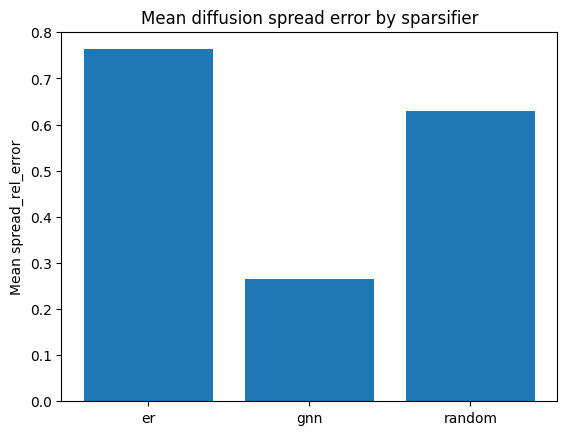

In [9]:
import matplotlib.pyplot as plt

summary = df.groupby("method")["spread_rel_error"].mean().reset_index()

plt.figure()
plt.bar(summary["method"], summary["spread_rel_error"])
plt.ylabel("Mean spread_rel_error")
plt.title("Mean diffusion spread error by sparsifier")
plt.show()


<Figure size 640x480 with 0 Axes>

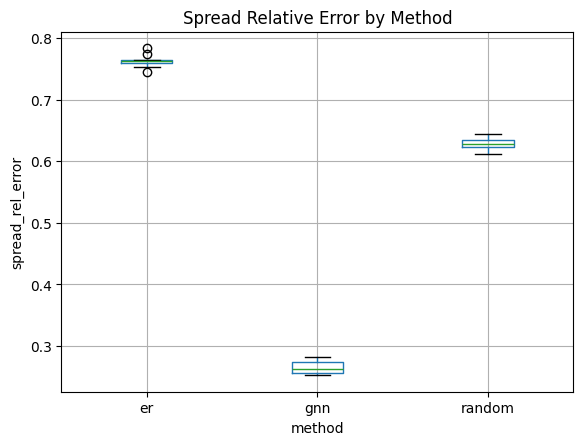

In [10]:
plt.figure()
df.boxplot(column="spread_rel_error", by="method")
plt.title("Spread Relative Error by Method")
plt.suptitle("")
plt.ylabel("spread_rel_error")
plt.show()


<Figure size 640x480 with 0 Axes>

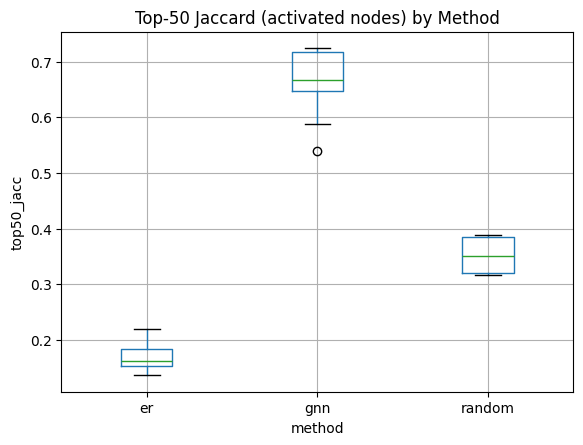

In [11]:
plt.figure()
df.boxplot(column="top50_jacc", by="method")
plt.title("Top-50 Jaccard (activated nodes) by Method")
plt.suptitle("")
plt.ylabel("top50_jacc")
plt.show()


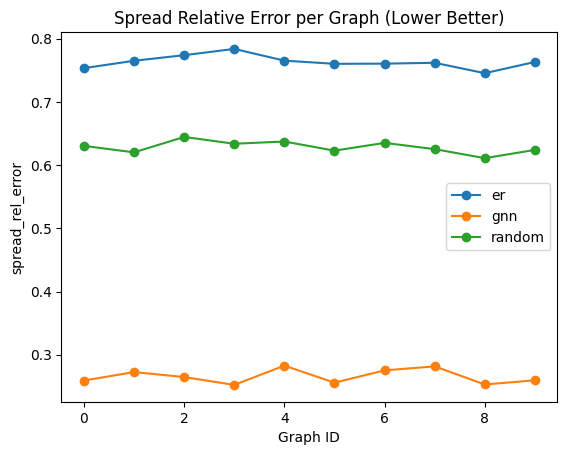

In [13]:
pivot = df.pivot(index="graph_id", columns="method", values="spread_rel_error")

plt.figure()
for method in pivot.columns:
    plt.plot(pivot.index, pivot[method], marker="o", label=method)

plt.xlabel("Graph ID")
plt.ylabel("spread_rel_error")
plt.title("Spread Relative Error per Graph (Lower Better)")
plt.legend()
plt.show()
